# Set up Data Generation

In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torch
from numpy import random
from sympy import *


In [2]:
sim = True
print(f"{'sim' if sim else 'hardware'}")

sim


In [3]:
g =  9.806
m = 1.55 if sim else 1.85
print(f"{m = } because {'sim' if sim else 'hardware'} mode is activated")

m = 1.55 because sim mode is activated


In [4]:
T_lookahead = 0.8
integration_step = 0.1
integrations = T_lookahead / integration_step
integrations_int = int(integrations)

In [5]:
C = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [6]:
def get_outputs(num_data_gen=100):
  allData = np.empty((0, 17))
  # print(allData)
  for i in range(num_data_gen):
    curr_thrust = random.uniform(0.0,27)
    curr_rolldot, curr_pitchdot, curr_yawdot = random.uniform(-0.9,0.9), random.uniform(-0.9,0.9), random.uniform(-0.9,0.9)

    xx = 2.0
    curr_x, curr_y, curr_z = random.uniform(-xx,xx), random.uniform(-xx,xx), random.uniform(0,-xx)

    vv = 1.0
    curr_vx, curr_vy, curr_vz = random.uniform(-vv,vv), random.uniform(-vv,vv), random.uniform(-vv,vv)

    ll = 12*np.pi
    curr_roll, curr_pitch, curr_yaw = random.uniform(-ll,ll), random.uniform(-ll,ll), random.uniform(-ll,ll)

    stateVector = [curr_x, curr_y, curr_z, curr_vx, curr_vy, curr_vz, curr_roll, curr_pitch, curr_yaw]
    inputVector = [curr_thrust, curr_rolldot, curr_pitchdot, curr_yawdot]

    cumm_change_x = 0.0
    cumm_change_y = 0.0
    cumm_change_z = 0.0
    cumm_change_vx = 0.0
    cumm_change_vy = 0.0
    cumm_change_vz = 0.0
    cumm_change_roll = 0.0
    cumm_change_pitch = 0.0
    cumm_change_yaw = 0.0

    xdot = curr_vx
    ydot = curr_vy
    zdot = curr_vz

    vxdot = -(curr_thrust/m) * (sin(curr_roll)*sin(curr_yaw) + cos(curr_roll)*cos(curr_yaw)*sin(curr_pitch));
    vydot = -(curr_thrust/m) * (cos(curr_roll)*sin(curr_yaw)*sin(curr_pitch) - cos(curr_yaw)*sin(curr_roll));
    vzdot = g - (curr_thrust/m) * (cos(curr_roll)*cos(curr_pitch));

    rolldot = curr_rolldot
    pitchdot = curr_pitchdot
    yawdot = curr_yawdot

    roll = curr_roll
    pitch = curr_pitch
    yaw = curr_yaw
    change_vx = 0
    change_vy = 0
    change_vz = 0

    for _ in range(integrations_int):
      change_x = (xdot+cumm_change_vx) * integration_step;
      change_y = (ydot+cumm_change_vy) * integration_step;
      change_z = (zdot+cumm_change_vz) * integration_step;
      change_vx = vxdot * integration_step;
      change_vy = vydot * integration_step;
      change_vz = vzdot * integration_step;
      change_roll = rolldot * integration_step;
      change_pitch = pitchdot * integration_step;
      change_yaw = yawdot * integration_step;

      roll = roll + change_roll;
      pitch = pitch + change_pitch;
      yaw =  yaw + change_yaw;

      sr = sin(roll)
      sy = sin(yaw)
      sp = sin(pitch)

      cr = cos(roll)
      cp = cos(pitch)
      cy = cos(yaw)


      vxdot = -(curr_thrust/m) * (sr*sy + cr*cy*sp);
      vydot = -(curr_thrust/m) * (cr*sy*sp - cy*sr);
      vzdot = g - (curr_thrust/m) * (cr*cp);


      cumm_change_x = cumm_change_x + change_x;
      cumm_change_y = cumm_change_y + change_y;
      cumm_change_z = cumm_change_z + change_z;
      cumm_change_vx = cumm_change_vx + change_vx;
      cumm_change_vy = cumm_change_vy + change_vy;
      cumm_change_vz = cumm_change_vz + change_vz;
      cumm_change_roll = cumm_change_roll + change_roll;
      cumm_change_pitch = cumm_change_pitch + change_pitch;
      cumm_change_yaw = cumm_change_yaw + change_yaw;


    x = curr_x + cumm_change_x
    y = curr_y + cumm_change_y
    z = curr_z + cumm_change_z
    # print(f"z: {z}")
    # print("\n")

    vx = curr_vx + cumm_change_vx
    vy = curr_vy + cumm_change_vy
    vz = curr_vz + cumm_change_vz

    roll = curr_roll + cumm_change_roll;
    pitch = curr_pitch + cumm_change_pitch;
    yaw = curr_yaw + cumm_change_yaw;

    nonlin_pred = np.array([[x, y, z, vx, vy, vz, roll, pitch, yaw]]).T
    outputs = C @ nonlin_pred

    outputs2 = outputs.squeeze().tolist()
    finalData = stateVector + inputVector + outputs2
    finalData = np.array(finalData, dtype=float)
    allData = np.vstack((allData, finalData))

  return allData

In [7]:
data_all = get_outputs(num_data_gen=50_000)

In [8]:
np.save('50k_iris_sim_expanded_more2' if sim else '50k_holybro_expanded_more2', data_all)
print(f"Saved under: {'50k_iris_sim_expanded_more2' if sim else '50k_holybro_expanded_more2'} because sim is {sim}")

Saved under: 50k_iris_sim_expanded_more2 because sim is True


# Set up Jax Neural Network Parameters and DataLoaders

## Data Loading is not in Jax, so we'll use torch loading

In [136]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import torch
sim = True


In [137]:
data_all = np.load('50k_iris_sim.npy' if sim else '50k_holybro.npy' )
print(f"Loaded {'50k_iris_sim.npy' if sim else '50k_holybro.npy'} because sim is {sim}")

Loaded 50k_iris_sim.npy because sim is True


In [138]:
class QuadrotorDataset(Dataset):
  def __init__(self, state_size = 9, ctrlinput_size = 4, training=True, data_all = data_all):
    self.input_size = state_size + ctrlinput_size
    self.output_size = ctrlinput_size
    np.random.shuffle(data_all)
    train_size = int(len(data_all)*0.8)
    if training:
      self.data = data_all[0:train_size]
    else:
      self.data = data_all[train_size:]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    inputs = self.data[idx, 0: self.input_size]
    outputs = self.data[idx, self.input_size:]
    return torch.FloatTensor(inputs), torch.FloatTensor(outputs).view(4)


In [139]:
train_dataset = QuadrotorDataset(training=True)
test_dataset = QuadrotorDataset(training=False)

In [140]:
batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [141]:
print(f"{train_dataloader.dataset.data.shape = }")
print(f"{test_dataloader.dataset.data.shape = }")

train_dataloader.dataset.data.shape = (40000, 17)
test_dataloader.dataset.data.shape = (10000, 17)


In [147]:
train_dataloader.dataset.data[0].shape

(17,)

## Set up Jax NN

In [67]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [96]:
input_size = 13
output_size = 4

num_epochs = 100
step_size = 1e-3
n_targets = output_size

In [97]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [input_size, 128, 256, 256, 128, output_size]
params = init_network_params(layer_sizes, random.key(0))


In [98]:
def relu(x):
  return jnp.maximum(0, x)

def predict(params, input):
  activations = input
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits

In [99]:
# This works on single examples
random_flattened_input = random.normal(random.key(1), (input_size,))
preds = predict(params, random_flattened_input)
print(preds.shape)
print(f"{preds = }")


(4,)
preds = Array([-0.00604843, -0.01136389, -0.01196619,  0.01512964], dtype=float32)


In [100]:
# Doesn't work with a batch
shape1 = (input_size,)
random_flattened_inputs = random.normal(random.key(1), shape1)
try:
  preds = predict(params, random_flattened_inputs)
  print(f"valid shape! {shape1}")
except TypeError:
  print(f'Invalid shapes! {shape1}')

print("\n")

num_samples = 10
shape1 = (num_samples, input_size)
random_flattened_inputs = random.normal(random.key(1), shape1)
try:
  preds = predict(params, random_flattened_inputs)
  print(f"valid shape! {shape1}")
except TypeError:
  print(f'Invalid shapes! {shape1}')

valid shape! (13,)


Invalid shapes! (10, 13)


In [101]:
# Let's upgrade it to handle batches using `vmap`
# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(params, random_flattened_inputs)
print(f"{batched_preds.shape = }")
print(f"{batched_preds = }")

batched_preds.shape = (10, 4)
batched_preds = Array([[-0.00604614, -0.0113606 , -0.01196401,  0.01513135],
       [-0.00604962, -0.01136125, -0.01196812,  0.01512348],
       [-0.00605041, -0.01135947, -0.01196369,  0.01512833],
       [-0.0060488 , -0.01136376, -0.01196304,  0.01512736],
       [-0.00605286, -0.01135952, -0.01196669,  0.01512857],
       [-0.00604817, -0.01135933, -0.01196317,  0.01512552],
       [-0.00605275, -0.01135965, -0.01196006,  0.0151287 ],
       [-0.00605385, -0.01136227, -0.01196395,  0.01512983],
       [-0.00605192, -0.01136083, -0.01196083,  0.01512848],
       [-0.00604921, -0.01136264, -0.01196166,  0.01512884]],      dtype=float32)


In [131]:
def accuracy(params, inputs, outputs):
  pred = batched_predict(params, inputs)
  loss = MSE(pred, outputs)
  return loss

def MSE(pred, target):
  return jnp.mean((pred - target)**2)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return MSE(preds, targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [132]:
train_input = np.array(train_dataset.data[:, :input_size])
train_output = np.array(train_dataset.data[:, input_size:])

test_input = np.array(test_dataset.data[:, :input_size])
test_output = np.array(test_dataset.data[:, input_size:])


In [134]:
import time

for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in train_dataloader:
    x, y = x.numpy(), y.numpy()  # Convert tensors to numpy
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(params, train_input, train_output)
  test_acc = accuracy(params, test_input, test_output)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

Epoch 0 in 0.78 sec
Training set accuracy 2.1700570583343506
Test set accuracy 2.156676769256592
Epoch 1 in 0.73 sec
Training set accuracy 2.164411783218384
Test set accuracy 2.1512367725372314
Epoch 2 in 0.76 sec
Training set accuracy 2.1602988243103027
Test set accuracy 2.1472995281219482
Epoch 3 in 0.72 sec
Training set accuracy 2.157299041748047
Test set accuracy 2.1444509029388428
Epoch 4 in 0.74 sec
Training set accuracy 2.1551198959350586
Test set accuracy 2.1424012184143066
Epoch 5 in 0.75 sec
Training set accuracy 2.153538227081299
Test set accuracy 2.1409270763397217
Epoch 6 in 0.71 sec
Training set accuracy 2.1523799896240234
Test set accuracy 2.1398627758026123
Epoch 7 in 0.74 sec
Training set accuracy 2.1515324115753174
Test set accuracy 2.139094352722168
Epoch 8 in 0.73 sec
Training set accuracy 2.150925397872925
Test set accuracy 2.1385552883148193
Epoch 9 in 0.74 sec
Training set accuracy 2.150480270385742
Test set accuracy 2.138167142868042
Epoch 10 in 0.75 sec
Trainin

# Set up Torch Neural Network Parameters and DataLoaders

In [148]:

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [149]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

In [150]:
data_all = np.load('50k_iris_sim.npy' if sim else '50k_holybro.npy' )
print(f"Loaded {'50k_iris_sim.npy' if sim else '50k_holybro.npy'} because sim is {sim}")
# data_all = np.load('50k_iris_sim2.npy')

Loaded 50k_iris_sim.npy because sim is True


In [162]:
class QuadrotorDataset(Dataset):
  def __init__(self, data_path = 'testing.csv', time_size=1, state_size = 9, ctrlinput_size = 4, training=True, data_all = data_all):
    self.input_size = state_size + ctrlinput_size
    self.output_size = ctrlinput_size

    self.data = data_all

    np.random.shuffle(data_all)
    train_size = int(len(data_all)*0.8)


    if training:
      self.data = data_all[0:train_size]
    else:
      self.data = data_all[train_size:]

    print(self.data.shape)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    # print(self.data[idx,:])
    inputs = self.data[idx, 0: self.input_size]
    outputs = self.data[idx, self.input_size:]
    # print(type(inputs))
    # print(type(outputs))
    # print(inputs)
    # print(inputs.dtype)
    # print("h")
    return torch.FloatTensor(inputs), torch.FloatTensor(outputs).view(4)


In [163]:
train_dataset = QuadrotorDataset(training=True)
test_dataset = QuadrotorDataset(training=False)

(40000, 17)
(10000, 17)


In [164]:
train_dataset[0][1].shape

torch.Size([4])

In [166]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
)
for data in train_dataloader:
    input_data, output_data = data
    print(input_data.shape)
    print(output_data.shape)
    print(output_data)
    print(output_data.dim())
    break

torch.Size([1, 13])
torch.Size([1, 4])
tensor([[-3.3642, -2.1191,  0.6514, -0.2020]])
2


(17,)

In [155]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [156]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

## Train PyTorch NNs

In [18]:
from torch import nn
import torch

### Feed Forward

In [35]:
class FeedForward(nn.Module):
    def __init__(self, input_size = 13, output_size = 4):
        super().__init__()
        self.feedfwd_stack = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.Linear(64, output_size)
        )
    def forward(self, x):
        logits = self.feedfwd_stack(x)
        return logits

In [36]:
class FeedForward(nn.Module):
    def __init__(self, input_size = 13, output_size = 4):
        super().__init__()
        self.feedfwd_stack = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.Linear(64, output_size)
        )
    def forward(self, x):
        logits = self.feedfwd_stack(x)
        return logits
model_FF = FeedForward()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, weight_decay=1e-5)
optimizer = torch.optim.AdamW(model_FF.parameters(), lr=learning_rate, weight_decay=1e-4)


criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
FF_accuracy_array = np.zeros(num_epochs)

def test_generalization(epoch):
    #Before training and at every stage of training
    total_loss = []
    with torch.no_grad():
      for data in test_dataloader:
        input_data, output_data = data

        output_pred = model_FF(input_data)
        loss = criterion(output_pred, output_data)

        total_loss.append(loss)


    average_loss = sum(total_loss) / len(total_loss)
    print(f"average loss in epoch #{epoch}: {average_loss * 100}")
    FF_accuracy_array[epoch] = average_loss * 100


# gradients_by_epoch = {param: [] for param in model_FF.parameters()}

loss_values = []

def train_feedfwd():
  #train:
  for epoch in range(num_epochs):

    # test before training starts and at every epoch
    test_generalization(epoch)



    #train over epochs
    total_loss = 0
    for data in train_dataloader:
        input_data, output_data = data

        output_pred = model_FF(input_data)
        loss = criterion(output_pred, output_data)

        optimizer.zero_grad()
        loss.backward()

        # for param in model_FF.parameters():
        #     gradients_by_epoch[param].append(param.grad.clone().detach())

        optimizer.step()

        # for param in model_FF.parameters():
        #     param.grad = None



#       optimizer.step()



        total_loss += loss.data
    scheduler.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss/12995*100))
    loss_values.append(total_loss/12995*100)

  test_generalization(epoch) #after final training

train_feedfwd()

average loss in epoch #0: 494.8470153808594
epoch [1/100], loss:1.2901
average loss in epoch #1: 11.781023025512695
epoch [2/100], loss:0.1281
average loss in epoch #2: 1.7660558223724365
epoch [3/100], loss:0.0362
average loss in epoch #3: 1.4340147972106934
epoch [4/100], loss:0.0348
average loss in epoch #4: 1.4543503522872925
epoch [5/100], loss:0.0350
average loss in epoch #5: 1.5021871328353882
epoch [6/100], loss:0.0350
average loss in epoch #6: 1.4400982856750488
epoch [7/100], loss:0.0354
average loss in epoch #7: 1.429140567779541
epoch [8/100], loss:0.0354
average loss in epoch #8: 1.4986463785171509
epoch [9/100], loss:0.0353
average loss in epoch #9: 1.4340816736221313
epoch [10/100], loss:0.0361
average loss in epoch #10: 1.459977626800537
epoch [11/100], loss:0.0355
average loss in epoch #11: 1.4948861598968506
epoch [12/100], loss:0.0357
average loss in epoch #12: 1.4514696598052979
epoch [13/100], loss:0.0356
average loss in epoch #13: 1.4631000757217407
epoch [14/100]

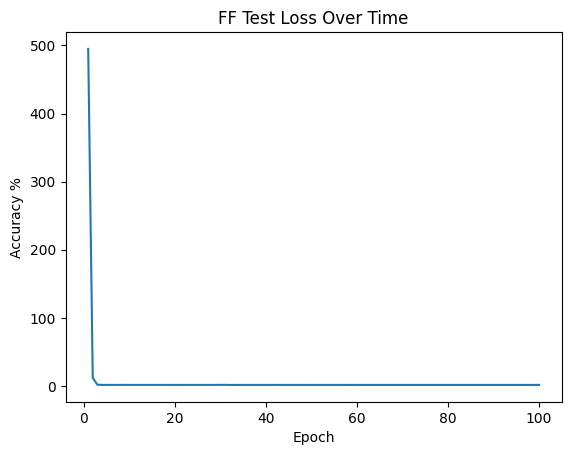

In [37]:
# Plot avg error over epochs
x = np.arange(1,num_epochs+1 , dtype = int)
fig, ax = plt.subplots()
plt.plot(x, FF_accuracy_array.T)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy %')
ax.set_title('FF Test Loss Over Time')
plt.show()

In [38]:
PATH = 'sim_ff.pt' if sim else "holybro_ff.pt"
torch.save(model_FF.state_dict(), PATH)
print(f"Saved to {'sim_ff.pt' if sim else 'holybro_ff.pt'} because sim is {sim}")

Saved to holybro_ff.pt because sim is False


### LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=13, hidden_size=64, num_layers=5, output_size=4):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out)

In [ ]:
# model = FeedForward()
modelLSTM = LSTMModel()

# optimizer = torch.optim.SGD(modelLSTM.parameters(), lr=learning_rate, momentum = 0.9, weight_decay=1e-5)
optimizer = torch.optim.AdamW(modelLSTM.parameters(), lr=learning_rate, weight_decay=1e-4)


criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
LSTM_accuracy_array = np.zeros(num_epochs)

In [ ]:
def test_generalization(epoch):
    #Before training and at every stage of training
    total_loss = []
    with torch.no_grad():
      for data in test_dataloader:
        input_data, output_data = data

        output_pred = modelLSTM(input_data)
        loss = criterion(output_pred, output_data)

        total_loss.append(loss)


    average_loss = sum(total_loss) / len(total_loss)
    print(f"average loss in epoch #{epoch}: {average_loss * 100}")
    LSTM_accuracy_array[epoch] = average_loss * 100


loss_values = []

def train_LSTM():
  #train:
  for epoch in range(num_epochs):

    # test before training starts and at every epoch
    test_generalization(epoch)



    #train over epochs
    total_loss = 0
    for data in train_dataloader:
        input_data, output_data = data

        output_pred = modelLSTM(input_data)
        loss = criterion(output_pred, output_data)

        optimizer.zero_grad()
        loss.backward()

        # for param in modelLSTM.parameters():
        #     gradients_by_epoch[param].append(param.grad.clone().detach())

        optimizer.step()

        # for param in modelLSTM.parameters():
        #     param.grad = None



#       optimizer.step()



        total_loss += loss.data
    scheduler.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss/12995*100))
    loss_values.append(total_loss/12995*100)

  test_generalization(epoch) #after final training


In [ ]:
train_LSTM()

average loss in epoch #0: 237.19927978515625
epoch [1/50], loss:4.5468
average loss in epoch #1: 145.5689239501953
epoch [2/50], loss:2.4372
average loss in epoch #2: 61.55756759643555
epoch [3/50], loss:0.5135
average loss in epoch #3: 6.690193176269531
epoch [4/50], loss:0.1539
average loss in epoch #4: 5.820988655090332
epoch [5/50], loss:0.1380
average loss in epoch #5: 5.6666579246521
epoch [6/50], loss:0.1345
average loss in epoch #6: 5.585153579711914
epoch [7/50], loss:0.1295
average loss in epoch #7: 5.232721328735352
epoch [8/50], loss:0.1265
average loss in epoch #8: 5.072952747344971
epoch [9/50], loss:0.1250
average loss in epoch #9: 5.45939826965332
epoch [10/50], loss:0.1232
average loss in epoch #10: 5.143733501434326
epoch [11/50], loss:0.1217
average loss in epoch #11: 5.009350299835205
epoch [12/50], loss:0.1215
average loss in epoch #12: 5.2815961837768555
epoch [13/50], loss:0.1203
average loss in epoch #13: 4.905193328857422


KeyboardInterrupt: 

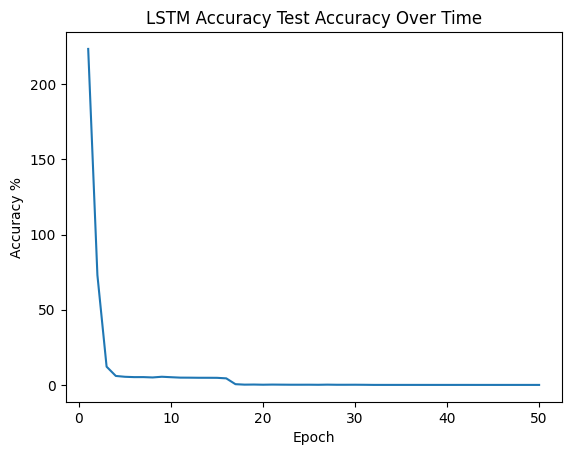

In [ ]:
# Plot avg error over epochs
x = np.arange(1,num_epochs+1 , dtype = int)
fig, ax = plt.subplots()
plt.plot(x, LSTM_accuracy_array.T)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy %')
ax.set_title('LSTM Accuracy Test Accuracy Over Time')
plt.show()

In [ ]:
PATH = "holybro_lstm.pt"
torch.save(modelLSTM.state_dict(), PATH)

### RNN

In [ ]:
# Define the RNN model class
num_epochs = 50
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
#         super(RNNModel, self).__init()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Define the output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # print(f"self.num_layers: {self.num_layers}")
        # print(f"x.size(0): {x.size(0)}")
        # print(f"self.hidden_size: {self.hidden_size}")
        out, _ = self.rnn(x, h0)

        # print(f"out.shape: {out.shape}")

        out = self.fc(out[-1, :, :])
        # print(f"out.shape: {out.shape}")
        # quit()
        return out



In [ ]:
# Set the input size, hidden size, number of layers, and output size
input_size = 13  # Example input size (adjust as needed)
hidden_size = 4  # Number of units in the hidden state
num_layers = 8  # Number of RNN layers
output_size = 4  # Example output size (adjust as needed)

# Create the RNN model
modelRNN = RNNModel(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(modelRNN.parameters(), lr=0.005)
# optimizer = torch.optim.SGD(modelRNN.parameters(), lr=learning_rate, momentum = 0.9, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
RNN_accuracy_array = np.zeros(num_epochs)


In [ ]:
def test_generalization(epoch):
    #Before training and at every stage of training
    total_loss = []
    with torch.no_grad():
      for data in test_dataloader:
        input_data, output_data = data


        # Add a batch dimension if necessary
        if input_data.dim() == 2:
            input_data = input_data.unsqueeze(0)

        output_pred = modelRNN(input_data)
        loss = criterion(output_pred, output_data)

        total_loss.append(loss)


    average_loss = sum(total_loss) / len(total_loss)
    print(f"average test error in epoch #{epoch}: {average_loss * 100}%")
    RNN_accuracy_array[epoch] = average_loss * 100



loss_values = []

def train_RNN():
  #train:
  for epoch in range(num_epochs):

    # test before training starts and at every epoch
    test_generalization(epoch)



    #train over epochs
    total_loss = 0
    for data in train_dataloader:
        input_data, output_data = data


        # Add a batch dimension if necessary
        if input_data.dim() == 2:
            input_data = input_data.unsqueeze(0)
        output_pred = modelRNN(input_data)
        loss = criterion(output_pred, output_data)

        optimizer.zero_grad()
        loss.backward()

        # for param in modelRNN.parameters():
        #     gradients_by_epoch[param].append(param.grad.clone().detach())

        optimizer.step()

        # for param in modelRNN.parameters():
        #     param.grad = None



#       optimizer.step()



        total_loss += loss.data
    scheduler.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss/12995*100))
    loss_values.append(total_loss/12995*100)

  test_generalization(epoch) #after final training


In [ ]:
train_RNN()

average test error in epoch #0: 254.60426330566406%
epoch [1/50], loss:4.0289
average test error in epoch #1: 137.67124938964844%
epoch [2/50], loss:2.8302
average test error in epoch #2: 81.06857299804688%
epoch [3/50], loss:1.6348
average test error in epoch #3: 60.07935333251953%
epoch [4/50], loss:1.3672
average test error in epoch #4: 56.19047927856445%
epoch [5/50], loss:1.2938
average test error in epoch #5: 53.27189636230469%
epoch [6/50], loss:1.2342
average test error in epoch #6: 50.5198974609375%
epoch [7/50], loss:1.1964
average test error in epoch #7: 51.494102478027344%
epoch [8/50], loss:1.1694
average test error in epoch #8: 48.17242431640625%
epoch [9/50], loss:1.1437
average test error in epoch #9: 48.737022399902344%
epoch [10/50], loss:1.1395
average test error in epoch #10: 46.74382781982422%
epoch [11/50], loss:1.1272
average test error in epoch #11: 46.799354553222656%
epoch [12/50], loss:1.1238
average test error in epoch #12: 46.32181167602539%
epoch [13/50], 

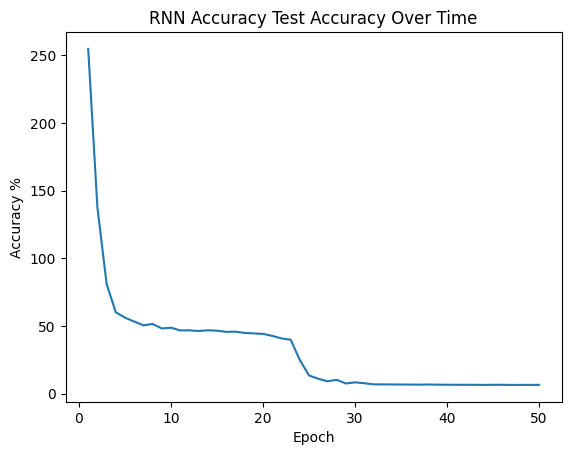

In [ ]:
# Plot avg error over epochs
x = np.arange(1,num_epochs+1 , dtype = int)
fig, ax = plt.subplots()
plt.plot(x, RNN_accuracy_array.T)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy %')
ax.set_title('RNN Accuracy Test Accuracy Over Time')
plt.show()

In [ ]:
PATH = "holybro_rnn.pt"
torch.save(modelRNN.state_dict(), PATH)

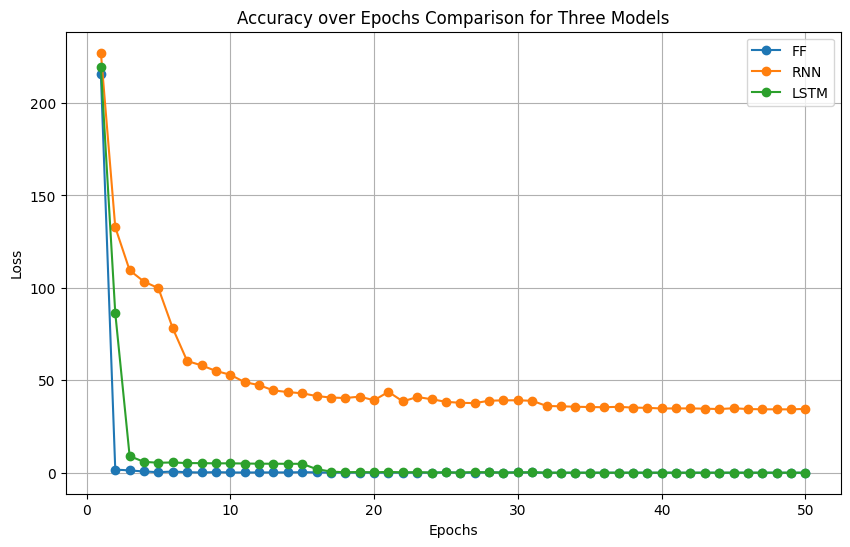

In [ ]:
# Create x-values (e.g., epochs)
epochs = range(1, num_epochs + 1)

# Plot the loss values for each model
plt.figure(figsize=(10, 6))
plt.plot(epochs, FF_accuracy_array, label='FF', marker='o')
plt.plot(epochs, RNN_accuracy_array, label='RNN', marker='o')
plt.plot(epochs, LSTM_accuracy_array, label='LSTM', marker='o')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy over Epochs Comparison for Three Models')
plt.legend()

# Show the plot
plt.grid()
plt.show()